# 0) Imports and functions


In [1]:
from PIL import Image
import numpy as np
from rasterio import rasterio
import pandas as pd

from matplotlib.colorbar import ColorbarBase
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)


In [2]:
def display(data, title="", axis="off", colorbar=False):
    plt.imshow(data, interpolation="nearest")
    plt.title(title)
    plt.axis(axis)
    if colorbar:
        plt.colorbar()
    plt.show()    

# 1) Archive content 
After extracting the dataset archive **(dataset.zip)** the following files should be available:  
```
binary_mask.png		sentinel2_2019_1.tif  sentinel2_2019_7.tif  
elevation.tif		sentinel2_2019_2.tif  sentinel2_2019_8.tif  
gc_potential.tif	sentinel2_2019_3.tif  sentinel2_2019_9.tif  
ma_potential.tif	sentinel2_2019_4.tif  vit_potential.tif  
pixels_to_stations.npy	sentinel2_2019_5.tif  weather_data.csv  
sentinel2_2019_10.tif	sentinel2_2019_6.tif
```



In [44]:
dataset_path = "../data/dataset/"
output_path = "./"

!ls $dataset_path


binary_mask.png		sentinel2_2019_1.tif  sentinel2_2019_7.tif
elevation.tif		sentinel2_2019_2.tif  sentinel2_2019_8.tif
gc_potential.tif	sentinel2_2019_3.tif  sentinel2_2019_9.tif
ma_potential.tif	sentinel2_2019_4.tif  vit_potential.tif
pixels_to_stations.npy	sentinel2_2019_5.tif  weather_data.csv
sentinel2_2019_10.tif	sentinel2_2019_6.tif


# 2) Binary Mask:
A binary mask is provided to determine the pixels that are considered in the study


/home/melsakka/Projects/agri-potential-dataset/agri_venv/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


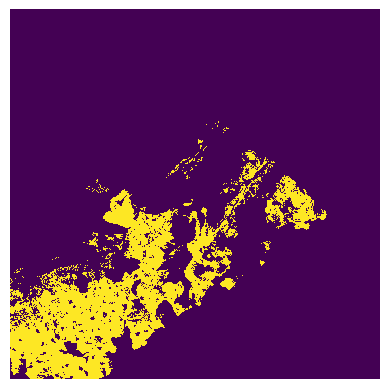

In [4]:
binary_mask_path = dataset_path+"binary_mask.png"
binary_mask = np.array(Image.open(binary_mask_path))
display(binary_mask)

## INFO
Given that a big region of the mask is unused, we will crop it in order to save some memory.  
By using the following function we can compute the coordinates of the boundaries of the mask.  
Experimentally, we determine that the **(up, down, left, right)** boundaries are **(3321, 10979, 0, 9401)**  
Therefore all following images (e.g. sentinel, labels) will be cropped according to these boundaries.


In [7]:
def compute_boundaries(binary_mask) -> tuple[int, int, int, int]:
    up, down, left, right = -1, -1, 1e8, -1
    last_down = 0
    for i in range(binary_mask.shape[0]):
        for j in range(binary_mask.shape[1]):
            if binary_mask[i][j] == 1 and up == -1:
                up = i
            if binary_mask[i][j] == 1 and last_down == 0 and i != down:
                down = i
            if binary_mask[i][j] == 1 and j<left:
                left = j
            if binary_mask[i][j] == 1 and j>right:
                right = j
            last_down = binary_mask[i][j]
    # Will return 3321 10979 0 9401
    return up, down, left, right

In [6]:
up, down, left, right =  3321, 10979, 0, 9401

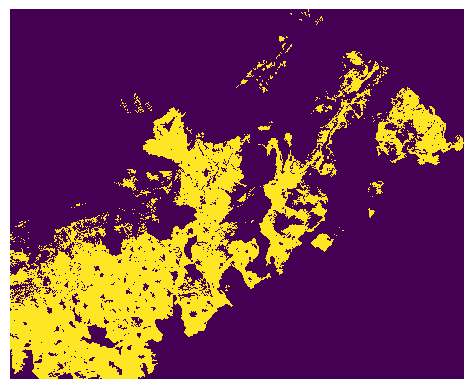

In [7]:
binary_mask = binary_mask[up:down+1, left:right+1]
display(binary_mask)

## INFO
Get pixel coordinates that are mapped

In [48]:
valid_indexes = np.argwhere(binary_mask == 1)
print(valid_indexes.shape)

(15985696, 2)


# 3) Labels
3 types of labels are provided:
- viticulture
- field crops (grandes cultures)
- market crops (maraîchages)

Given that labels have 5 intensities (very limited, limited, moderate, high, very high), the files are in 5-channel Tif files in a one-hot encoding categorical format
  

## Example on viticulture

Channels: 5
Dimensions: 10980x10980
(5, 10980, 10980)


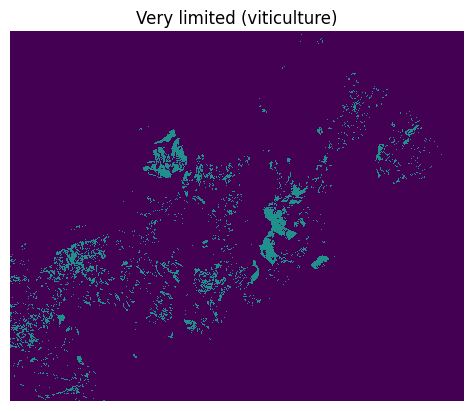

In [45]:
viticulture_path = dataset_path+"vit_potential.tif"
# field_crops_path = dataset_path+"gc_potential.tif"
# market_crops_path = dataset_path+"ma_potential.tif"

viticulture_data = rasterio.open(viticulture_path)
print(f"Channels: {viticulture_data.count}")
print(f"Dimensions: {viticulture_data.height}x{viticulture_data.width}")

viticulture_labels = viticulture_data.read()
print(viticulture_labels.shape)

display(viticulture_labels[0,:,:][up:down+1, left:right+1], title="Very limited (viticulture)")


## Displaying categorical labels on 1 plot 
### Example on viticulture

In [49]:
viticulture_labels = viticulture_data.read()
viticulture_labels = np.transpose(viticulture_labels, (1,2,0)) # h.w.c
viticulture_labels = np.argmax(viticulture_labels, axis=-1)[up:down+1, left:right+1]
viticulture_labels = np.where(binary_mask, viticulture_labels, np.nan) # We use the binary mask to not include other pixels in labels
viticulture_labels = viticulture_labels
print(viticulture_labels.shape)


(7659, 9402)


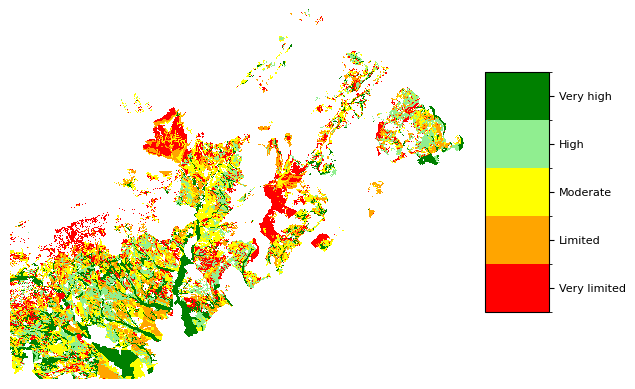

In [77]:
colors = ["red", "orange", "yellow", "lightgreen", "green"]
labels = ["Very limited", "Limited", "Moderate", "High", "Very high"]
cmap = ListedColormap(colors)
bounds = np.linspace(0, 5, 6)
norm = BoundaryNorm(bounds, cmap.N)
fig = plt.figure()
plt.imshow(viticulture_labels, cmap=cmap, norm=norm, interpolation="nearest")
plt.axis("off")
ax = fig.add_axes([0.9, 0.25, 0.1, 0.5])
colorbar = ColorbarBase(ax, orientation='vertical',cmap=cmap, norm=norm)
colorbar.set_ticks(np.arange(0.5, 5.5))
colorbar.set_ticklabels(labels, fontsize=8)
plt.show()

# 4) Elevation
Elevation data is a 1D array saved as a Tif file

Channels: 1


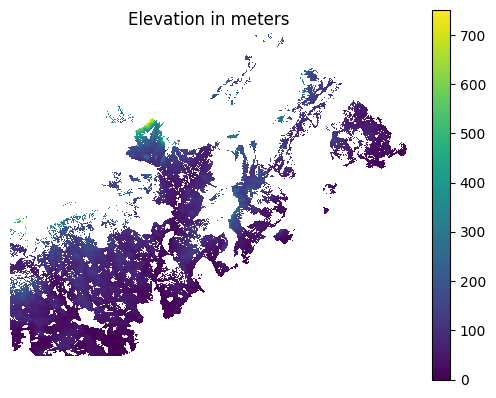

In [91]:
elevation_data_path = dataset_path+"elevation.tif"
elevation_data = rasterio.open(elevation_data_path)
print(f"Channels: {elevation_data.count}")
elevation = elevation_data.read(1)[up:down+1, left:right+1]
elevation = np.where(binary_mask, elevation, np.nan)
display(elevation, title="Elevation in meters", colorbar=True)

# Sentinel-2
There are 10 sentinel-2 images across the year 2019. Those are the available images that have low cloud coverage (<2%).  
Each S2 image is saved in a file: **sentinel2_2019_{ID}.tif** where **ID** is a number between 1 and 10 (January - October).  
Each S2 image has 4 channels (bands), resp. Blue (B02), Green (B03), Red (B04), Near Infared (B08), at 10m/pixel resolution.    
The values found in each channel correspond to the reflectance recorded by the satellite instruments, and thus, is not a value between 0 and 255, so for **visualization**, these values need to be normalized first.
Quick-ref on Sentinel-2:  
https://gisgeography.com/sentinel-2-bands-combinations/


## Example on an image from March 2019

In [6]:
s2_data_path = dataset_path+"sentinel2_2019_1.tif"
s2_data = rasterio.open(s2_data_path)
print(f"Channels: {s2_data.count}")

Channels: 4


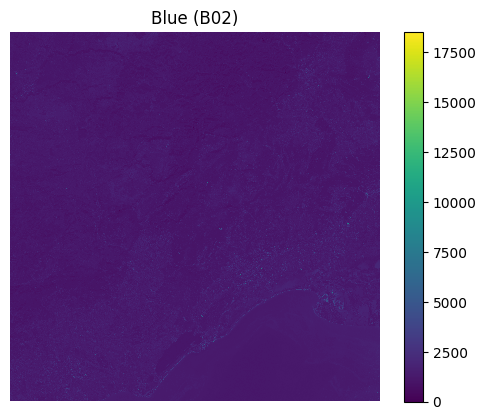

In [11]:
band_names = ["Blue (B02)", "Green (B03)", "Red (B04)", "NIR (B08)"]
s2_image = s2_data.read()
for i in range(s2_image.shape[0]):
    display(s2_image[i,:,:], title=band_names[i], colorbar=True)
    break

## After normalization

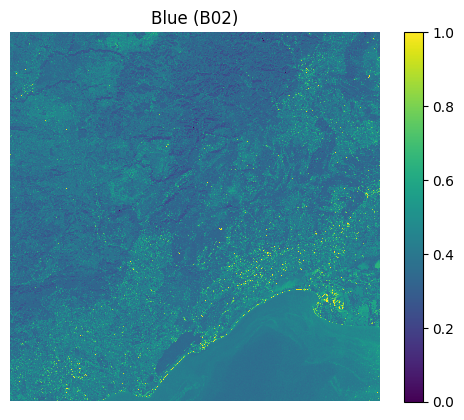

In [12]:
def brighten(data: np.ndarray) -> np.ndarray:
    alpha=0.08
    beta=0
    return np.clip(alpha*data+beta, 0,255)

def normalize(data: np.ndarray) -> np.ndarray:
    data_min, data_max = (data.min(), data.max())
    return ((data-data_min)/((data_max - data_min)))

band_names = ["Blue (B02)", "Green (B03)", "Red (B04)", "NIR (B08)"]
s2_image = s2_data.read()
for i in range(s2_image.shape[0]):
    display(normalize(brighten(s2_image[i,:,:])), title=band_names[i], colorbar=True)
    break
    

## We can also construct a color image from the channels R G B

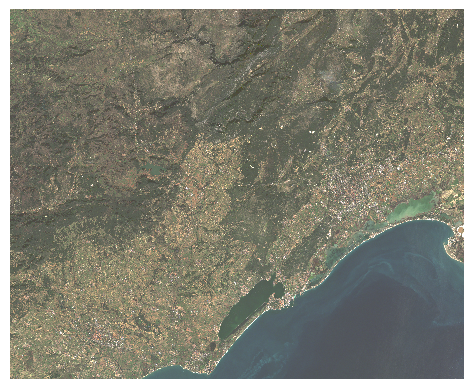

In [21]:
r = normalize(brighten(s2_data.read(3)))[up:down+1, left:right+1]
g = normalize(brighten(s2_data.read(2)))[up:down+1, left:right+1]
b = normalize(brighten(s2_data.read(1)))[up:down+1, left:right+1]

rgb = np.dstack([r,g,b])
display(rgb)

# Weather data  

In the department of Herault, we chose 15 weather stations depending on the availability of data. 
The recorded data includes on a 10-day period basis:  
- A distinct station ID, name, Lat, Lon
- The average temperature in °C
- The Max temperature in °C
- The Min temperature in °C
- Precipitation in mm
- The date in YYYYMM_X format where X is {1,2,3} according to which 10-day period is recorded. For example, ```the period 10-20 of february 2019 has the date 201902_2```

The data is available under a tabular format in a csv file.  
A mapping of each pixel to the station that it belongs to is found in pixels_to_stations.npy  
Tutorial below

In [ ]:
weather_data_path = dataset_path+"weather_data.csv"
weather_data = pd.read_csv(weather_data_path)
weather_data

,ID,NOM_USUEL,LAT,LON,Date,Temperature,Max Temperature,Min Temperature,Precipitation
0,10,BEZIERS-COURTADE,43.334333,3.155000,201902_1,8.7,13.7,3.7,2.2
1,10,BEZIERS-COURTADE,43.334333,3.155000,201902_2,9.2,15.1,3.4,0.4
2,10,BEZIERS-COURTADE,43.334333,3.155000,201902_3,10.2,19.8,0.6,0.8
3,10,BEZIERS-COURTADE,43.334333,3.155000,201903_1,12.4,17.9,6.9,0.0
4,10,BEZIERS-COURTADE,43.334333,3.155000,201903_2,10.9,17.0,4.8,0.0
...,...,...,...,...,...,...,...,...,...
522,24,VILLENEUVE-LES-MAG-INRAE,43.538167,3.853833,201911_2,8.1,12.7,3.5,3.5
523,24,VILLENEUVE-LES-MAG-INRAE,43.538167,3.853833,201911_3,12.4,15.9,8.8,46.0
524,24,VILLENEUVE-LES-MAG-INRAE,43.538167,3.853833,201912_1,9.5,13.7,5.3,3.0
525,24,VILLENEUVE-LES-MAG-INRAE,43.538167,3.853833,201912_2,12.4,15.0,9.7,17.5


(7659, 9402)


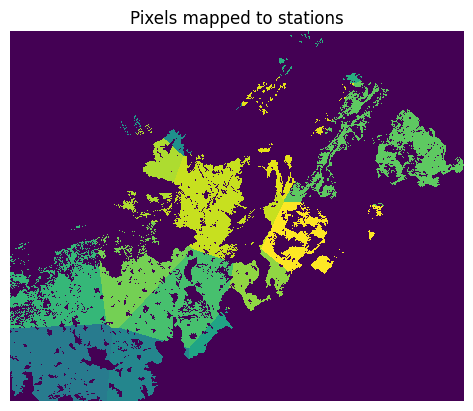

In [10]:
pixels_to_stations = np.load(dataset_path+"pixels_to_stations.npy")[0][up:down+1, left:right+1]
print(pixels_to_stations.shape)
display(pixels_to_stations, title="Pixels mapped to stations")

In [11]:
print(f"Station IDs: (0 for non mapped pixels) {np.unique(pixels_to_stations)} ")

Station IDs: (0 for non mapped pixels) [ 0. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.] 


In [ ]:
np.random.seed(0)
valid_indexes = np.argwhere(binary_mask == 1)
random_pixel = valid_indexes[np.random.choice(valid_indexes.shape[0])]
station_id = pixels_to_stations[random_pixel[0], random_pixel[1]]
print(f"Random pixel coordinates: {random_pixel} belongs to station {station_id}")
data = weather_data[weather_data["ID"] == station_id]

print("Weather data for this pixel over time:")
print("-------------------------------------")
print(f"{'Date':<10} {'Temp':<10} {'MaxTemp':<10} {'MinTemp':<10} {'Prec':<10}")
for date, temp, max_temp, min_temp, precep in zip(data["Date"], 
                                                data["Temperature"],
                                                data["Max Temperature"],
                                                data["Min Temperature"],
                                                data["Precipitation"]):
    print(f"{date:<10} {temp:<10} {max_temp:<10} {min_temp:<10} {precep:<10}")


Random pixel coordinates: [5225 4305] belongs to station 17.0
Weather data for this pixel over time:
-------------------------------------
Date       Temp       MaxTemp    MinTemp    Prec      
201901_1   6.4        10.2       2.6        0.0       
201901_2   7.6        11.7       3.4        2.2       
201901_3   6.0        10.0       2.1        12.0      
201902_1   9.1        13.6       4.6        4.2       
201902_2   9.2        14.7       3.7        1.0       
201902_3   11.5       19.4       3.6        0.8       
201903_1   12.6       17.8       7.3        0.0       
201903_2   11.6       16.8       6.3        0.2       
201903_3   12.2       20.0       4.5        0.0       
201904_1   11.5       17.0       6.0        19.0      
201904_2   13.6       18.8       8.3        4.2       
201904_3   15.0       19.3       10.8       10.2      
201905_1   14.3       19.7       8.9        9.0       
201905_2   15.3       20.9       9.7        18.0      
201905_3   19.4       24.9       13.